### IMBH Forecast

TODO:
- obscured fraction
- dust extinction/reddening effects
- 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.constants as const
from astropy.timeseries import LombScargle
from taufit import simulate_from_psd, smoothly_broken_power_law, fit_drw

from tqdm.notebook import tqdm

import scipy.stats as st

from astropy.cosmology import FlatLambdaCDM, z_at_value
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

import xspec
#import pyphot
from pyphot import astropy as pyphot
from labellines import labelLine, labelLines

# https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node205.html#optxagnf
xspec.Xset.allowPrompting = False

In [2]:
from model import DemographicModel, ERDF

In [3]:
def set_mpl_style():
    
    """Function to set MPL style"""
    
    fsize = 15
    tsize = 18
    tdir = 'in'
    major = 5.0
    minor = 3.0
    lwidth = 1.8
    lhandle = 2.0
    plt.style.use('default')
    plt.rcParams['text.usetex'] = False
    plt.rcParams['font.size'] = fsize
    plt.rcParams['legend.fontsize'] = tsize
    plt.rcParams['xtick.direction'] = tdir
    plt.rcParams['ytick.direction'] = tdir
    plt.rcParams['xtick.major.size'] = major
    plt.rcParams['xtick.minor.size'] = minor
    plt.rcParams['ytick.major.size'] = 5.0
    plt.rcParams['ytick.minor.size'] = 3.0
    plt.rcParams['axes.linewidth'] = lwidth
    plt.rcParams['legend.handlelength'] = lhandle
    
    return

In [4]:
set_mpl_style()

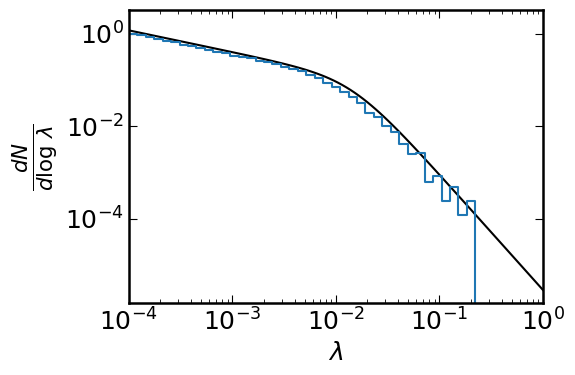

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

l = np.logspace(-4, 0, 100)
dlogl = np.diff(np.log10(l))[0]
p = ERDF(l)*dlogl
p = p/np.sum(p)
s = np.random.choice(l, 100000, p=p)

ax.loglog(l, p/dlogl, c='k')

bins = np.logspace(-4, 0, 50)
h, bin_edges = np.histogram(s, bins=bins)
ax.step(bin_edges[:-1], h/np.diff(np.log10(bins))[0]/len(s))

ax.set_xlabel(r'$\lambda$', fontsize=18)
ax.set_ylabel(r'$\frac{dN}{d\log\ \lambda}$', fontsize=22)

ax.tick_params('both', labelsize=18)
ax.tick_params(axis='both', which='both', direction='in')
ax.tick_params(axis='both', which='major', length=6)
ax.tick_params(axis='both', which='minor', length=3)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

ax.set_xlim(1e-4, 1e0)

fig.tight_layout()

### Load previous model instance

In [6]:
model = DemographicModel()
model.sample(nbins=16, nbootstrap=5, zmax=0.15, eta=1e3) #1e3

  0%|          | 0/5 [00:00<?, ?it/s]

834850
757525
582480
697813
171458


/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


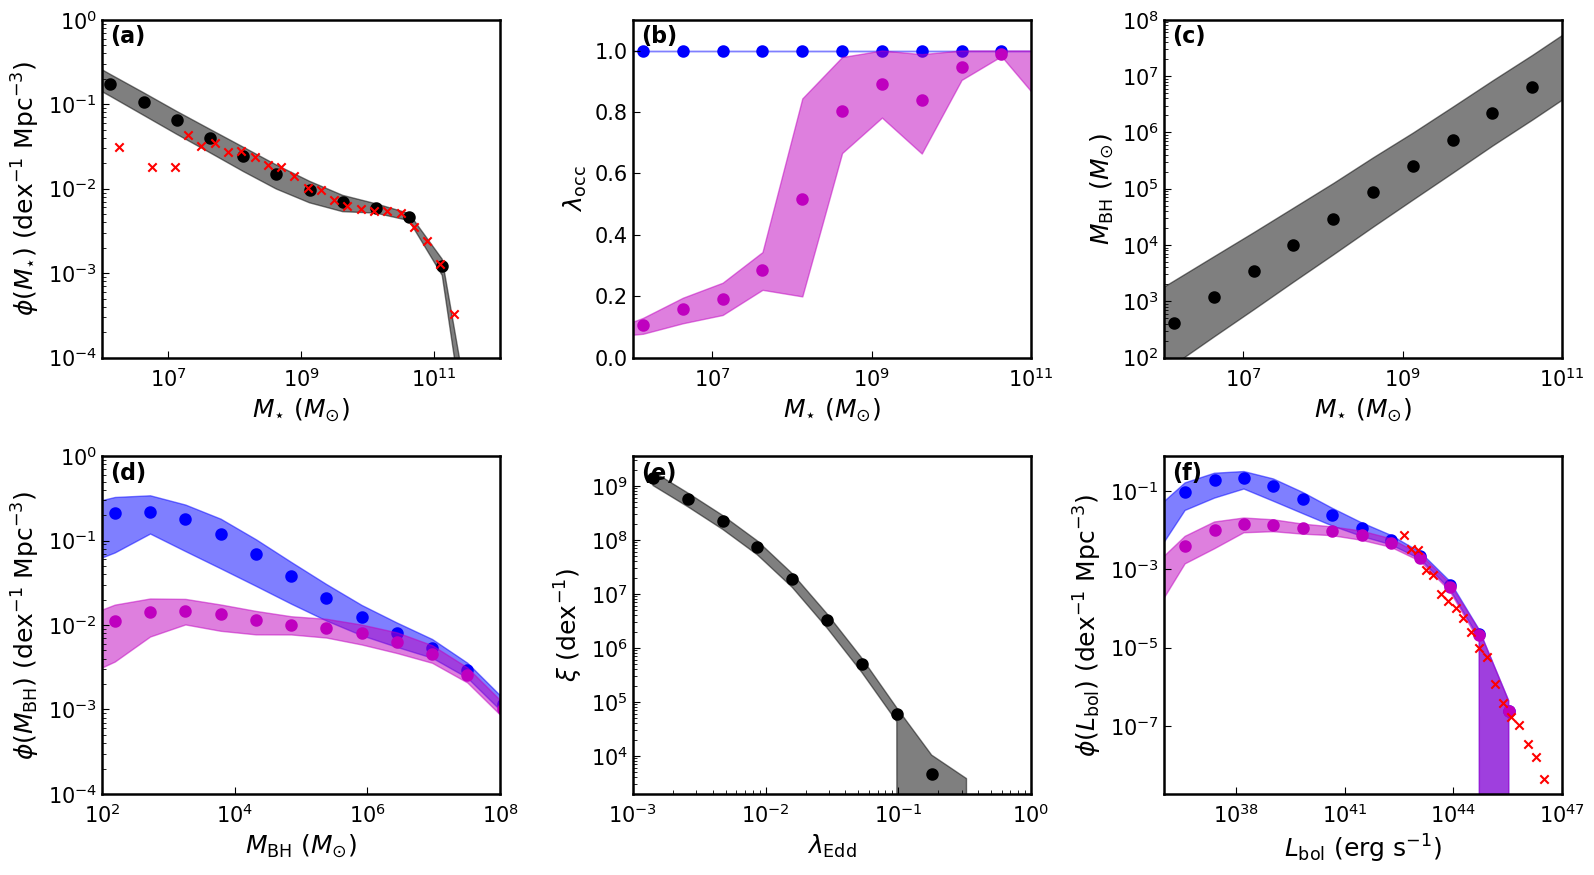

In [7]:
fig = model.plot()
fig.savefig('model.pdf', dpi=300)

In [ ]:
band = 'SDSS_g'

model.sample_sed_grid(band=band)

Setting up model SED
Creating SED grid in band SDSS_g


In [9]:
s = model.samples
pars = model.pars

In [ ]:
s[f'L_draw_popIII'].value[s[f'L_draw_popIII'].value>0]

In [ ]:
plt.scatter(np.log10(s[f'L_draw_popIII'].value), np.log10(s[f'L_{band}'].value), s=0.1)
#plt.scatter(np.log10(s[f'M_BH_draw'].value), np.log10(-s[f'L_{band}'].value))

In [ ]:
pts = np.array([[2.1, 6.2, 8.3], [3.3, 5.2, 7.1]])
pts.shape

In [ ]:
plt.scatter(np.log10(s[f'L_draw_popIII'].value), s[f'M_i'], s=0.1)

In [ ]:
#np.log10()

In [ ]:
plt.hist(np.log10(s[f'L_{band}'][np.isfinite(s[f'L_{band}'])].value), log=True)

### Mock Observations: light curves

In [10]:
num_seasons = 10
season_duration = 95 # days
cadence = 20 # days
t_obs = [np.arange(365*i, 365*i + season_duration, cadence) for i in range(num_seasons)]
t_obs = np.array(t_obs).flatten()

model.sample_light_curves(t_obs, band=band)

Sampling light curves with seeding mechanism dc


  0%|          | 0/5 [00:00<?, ?it/s]

KeyError: 'M_i'

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

m_eval = np.linspace(15, 25)

def pm_prec(mag):
    gamma = 0.038
    m_5 = 25.0
    
    sigma_sys = 0.003
    x = 10**(0.4*(mag - m_5))
    sigma_rand = np.sqrt((0.04 - gamma)*x + gamma*x**2)
    return np.sqrt(sigma_sys**2 + sigma_rand**2)

ax.plot(m_eval, 1e3*pm_prec(m_eval), color='gray', lw=3)
ax.set_xlim(15.5, 25.5)
ax.set_ylim(0, 200)
ax.set_ylabel(r'$\sigma_{g}$ (mmag)')
ax.set_xlabel(r'$g$ (mag)')

fig.tight_layout()
fig.savefig('phprec.pdf', dpi=300)

In [ ]:
def calc_sigma_var(mag, magerr):
    
    N = np.shape(mag)[0] # Number of light curves
    nu = np.shape(mag)[1] - 1
    
    wt = 1/magerr**2
    m0 = np.sum(mag*wt, axis=1)/np.sum(wt, axis=1)
    m0 = np.array([m0]*(nu+1)).T # Reshape
        
    chisq = 1/nu*np.sum((mag - m0)**2*wt, axis=1)
    
    p = st.chi2.sf(chisq, nu) #1 - cdf
    
    log_p = np.log(p)
    
    sigma_var = np.zeros_like(p)
    
    mask_small = (log_p > -36)
    
    sigma_var[mask_small] = st.norm.ppf(1 - p[mask_small]/2)
    sigma_var[~mask_small] = np.sqrt(np.log(2/np.pi) - 2*np.log(8.2) - 2*log_p[~mask_small])
        
    return sigma_var

In [ ]:
from tools import myvarlc, p2sigma
from statsmodels.stats.diagnostic import acorr_ljungbox


nbootstrap = pars['nbootstrap']

ndraws = 10000000
s['sigma_var'] = np.full([nbootstrap, ndraws], np.nan)
#sigma_lb = np.full([nbootstrap, ndraws], np.nan)

for j in range(pars['nbootstrap']):
    ndraw = int(s['ndraws'][j])
    mag = s[f'lc_{band}'][j,:ndraw]
    magerr = pm_prec(mag)
    s['sigma_var'][j,:ndraw] = calc_sigma_var(mag, magerr)

In [ ]:
mask = (s[f'sigma_var'] > 3)
mag = s[f'lc_{band}'][mask][0]
plt.errorbar(t_obs, mag, yerr=pm_prec(mag))
calc_sigma_var(np.array([mag]), np.array([pm_prec(mag)]))

In [ ]:
from model import lambda_obs
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
L = np.logspace(np.min(np.log10(pars['L'].value)), np.max(np.log10(pars['L'].value)), 100)*u.erg/u.s

n = 200

lambdas = np.zeros([n, len(L)])
for j in range(n):
    lambdas[j,:] = lambda_obs(L.value)
    
    
ax.fill_between(L, np.percentile(lambdas, 16, axis=0),
                np.percentile(lambdas, 16, axis=0),
                color='gray', lw=2)

ax.set_xlabel(r'$L_{\rm{bol}}$ (erg s$^{-1}$)')
ax.set_ylabel(r'$\lambda_{\rm{obs}}$')
ax.set_xscale('log')

ax.text(1e38, 0.4, 'Type II')
ax.text(1e45, 0.9, 'Type I')

ax.set_xlim(np.min(L.value), np.max(L.value))

fig.tight_layout()
fig.savefig('obs.pdf', dpi=300)

In [61]:
s.keys()

dict_keys(['zmax', 'zmin', 'M_star_draw', 'M_star_draw_test', 'n_i_M', 'z_draw', 'M_BH_draw', 'M_BH_draw_dc', 'M_BH_draw_popIII', 'n_i_M_dc', 'n_i_M_popIII', 'lambda_draw', 'n_i_Edd', 'L_draw_popIII', 'L_draw_dc', 'n_i_L_popIII', 'n_i_L_dc', 'ndraws', 'L_SDSS_g', 'M_i', 'L_SDSS_g_model', 'M_i_model', 'lc_SDSS_g', 'm_SDSS_g', 'lc_t_obs', 'SFinf_SDSS_g', 'tau_RF_SDSS_g', 'L_host_SDSS_g', 'sigma_var'])

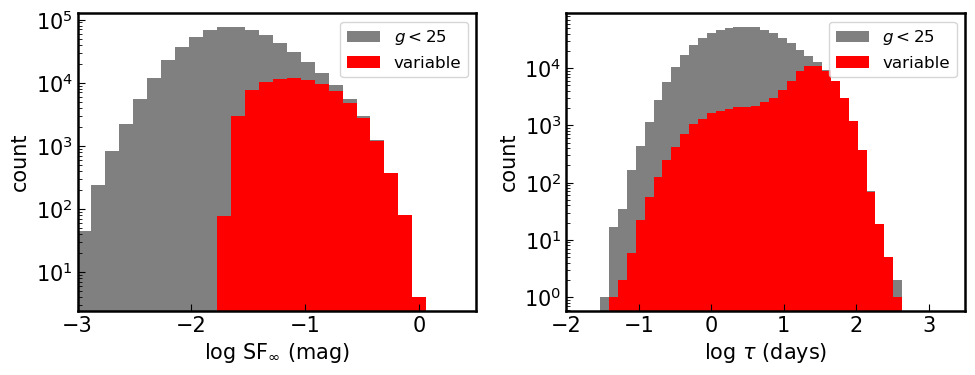

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(5*2, 4))

bins = np.linspace(-3, 3)

mask_nan = np.isfinite(s[f'SFinf_{band}']) & np.isfinite(s[f'tau_RF_{band}'])
mask_mass = s['M_BH_draw'] > 1e2*u.Msun
mask_SF = s[f'SFinf_{band}'] > pm_prec(s[f'm_{band}'])
mask_tau = s[f'tau_RF_{band}'] > 3
mask_mag = s[f'm_{band}'] < 25
mask_var = s['sigma_var'] > 3

#axs[0].hist(np.log10(s[f'SFinf_{band}'][mask_nan & mask_mag]), bins=bins, color='gray', label=r'$g<25$')
#axs[0].hist(np.log10(s[f'SFinf_{band}'][mask_nan & mask_tau & mask_SF]), bins=bins, color='r', label='variable')

axs[0].hist(np.log10(s[f'SFinf_{band}'][mask_mass & mask_mag]), bins=bins, color='gray', label=r'$g<25$', log=True)
axs[0].hist(np.log10(s[f'SFinf_{band}'][mask_mass & mask_var]), bins=bins, color='r', label='variable')

axs[0].set_xlim(-3, 0.5)
ax.set_ylim(0, 1500)

axs[0].set_xlabel(r'$\log\ \rm{SF}_{\infty}$ (mag)')
axs[0].set_ylabel(r'count')

axs[0].legend(fontsize=12)


bins = np.linspace(-3, 3)

#axs[1].hist(np.log10(s[f'tau_{band}'][mask_nan & mask_mag]), bins=bins, color='gray', label=r'$g<25$')
#axs[1].hist(np.log10(s[f'tau_{band}'][mask_nan & mask_tau & mask_SF]), bins=bins, color='r', label='variable')

axs[1].hist(np.log10(s[f'tau_RF_{band}'][mask_mass & mask_mag]), bins=bins, color='gray', label=r'$g<25$', log=True)
axs[1].hist(np.log10(s[f'tau_RF_{band}'][mask_mass & mask_var]), bins=bins, color='r', label='variable')
axs[1].set_xlim(-2.0, 3.5)

axs[1].set_xlabel(r'$\log\ \tau$ (days)')
axs[1].set_ylabel(r'count')


axs[1].legend(fontsize=12)

fig.tight_layout()
fig.savefig('var.pdf', dpi=300)

In [ ]:
import corner

In [ ]:
z = s['z_draw'][mask_mass & mask_mag & mask_var]
x = np.log10(s[f'SFinf_{band}'][mask_mass & mask_mag & mask_var])
y = np.log10(s[f'tau_RF_{band}'][mask_mass & mask_mag & mask_var]*(1 + z))

fig = corner.corner(np.array([x, y]).T, color='red', labels=['SF', 'tau'])

# Non-variable
z = s['z_draw'][mask_mass & mask_mag]
x = np.log10(s[f'SFinf_{band}'][mask_mass & mask_mag])
y = np.log10(s[f'tau_RF_{band}'][mask_mass & mask_mag]*(1 + z))

#corner.corner(np.array([x, y]).T, fig=fig, color='gray')


In [19]:
mask_mag = s[f'm_{band}'] < 25

z = s['z_draw'][mask_mass & mask_var]
plt.scatter(np.log10(s[f'SFinf_{band}'][mask_mass & mask_var]),
            np.log10(s[f'tau_RF_{band}'][mask_mass & mask_var]*(1 + z)),
            color='red', s=1, zorder=1)
z = s['z_draw'][mask_mass & mask_mag]
plt.scatter(np.log10(s[f'SFinf_{band}'][mask_mass & mask_mag]),
            np.log10(s[f'tau_RF_{band}'][mask_mass & mask_mag]*(1 + z)),
            color='gray', s=.01, zorder=0)
plt.gca().set_xlim(-3, 0.0)

# Why the large tau branch?

# OK, try bumping up stellar mass and BH mass to 1e13

KeyError: 'm_SDSS_g'

In [85]:
mask_mass = s['M_BH_draw'] > 1e2*u.Msun
mask_mag = s[f'm_{band}'] < 25

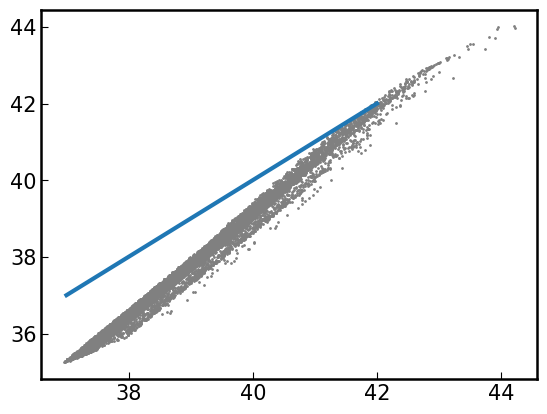

In [86]:
plt.scatter(np.log10(s[f'L_draw_popIII'][mask_mass & mask_mag].value), np.log10(s[f'L_{band}'][mask_mass & mask_mag].value),
            color='gray', s=1)
#plt.scatter(np.log10(s[f'L_draw_popIII'][mask_mass & mask_var].value), np.log10(s[f'L_{band}'][mask_mass & mask_var].value),
#            color='red', s=.01)
plt.plot([37, 42], [37, 42], lw=3)

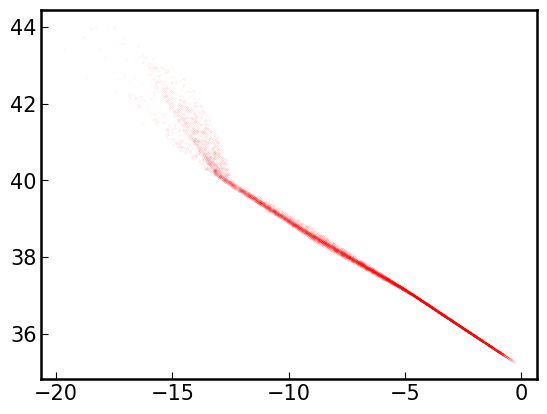

In [87]:
plt.scatter(s[f'M_i'][mask_mass & mask_mag], np.log10(s[f'L_{band}'][mask_mass & mask_mag].value), color='red', s=.001)

Text(0.5, 0, '$g$')

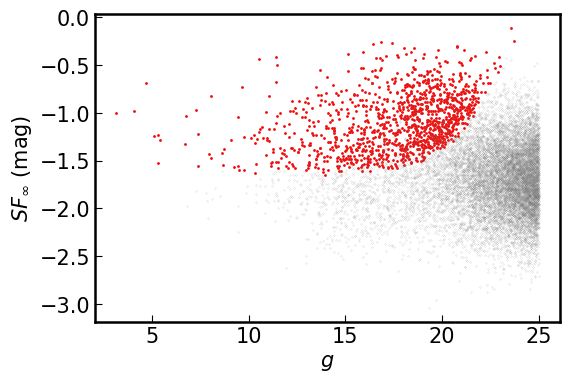

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.scatter(s[f'm_{band}'][mask_mass & mask_var], np.log10(s[f'SFinf_{band}'][mask_mass & mask_var]), color='red', s=1)
plt.scatter(s[f'm_{band}'][mask_mag], np.log10(s[f'SFinf_{band}'][mask_mag]), s=.01, color='gray')
ax.set_ylabel(r'$SF_{\infty}$ (mag)')
ax.set_xlabel(r'$g$')

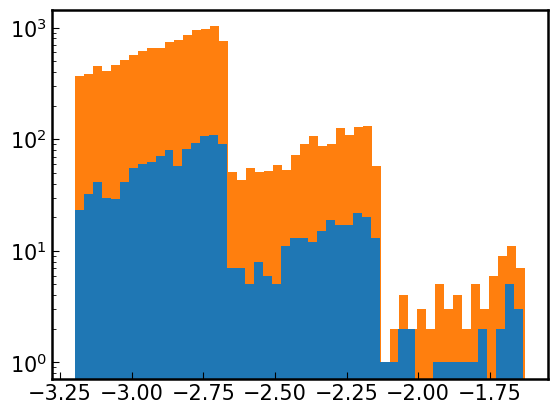

In [94]:
plt.hist(np.log10(s[f'lambda_draw'][mask_mag & mask_var]), log=True, bins=50)
plt.hist(np.log10(s[f'lambda_draw'][mask_mag]), log=True, zorder=-1, bins=50);
# This is interesting

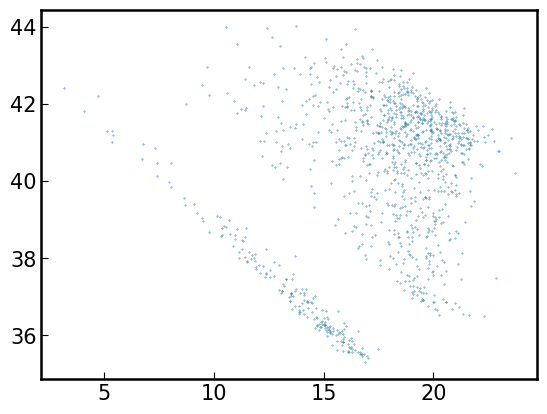

In [140]:
plt.scatter(s[f'm_{band}'][mask_mass & mask_var], np.log10(s[f'L_{band}'][mask_mass & mask_var].value), s=0.1)

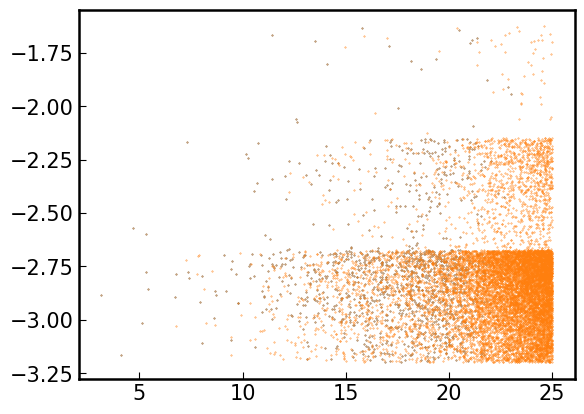

In [96]:
plt.scatter(s[f'm_{band}'][mask_mass & mask_var], np.log10(s[f'lambda_draw'][mask_mass & mask_var]), s=0.1)
plt.scatter(s[f'm_{band}'][mask_mag], np.log10(s[f'lambda_draw'][mask_mag]), s=.1)
# The cuts here is because there is a range of L/L_Edd, cutoff at -9 unlikely to be 1

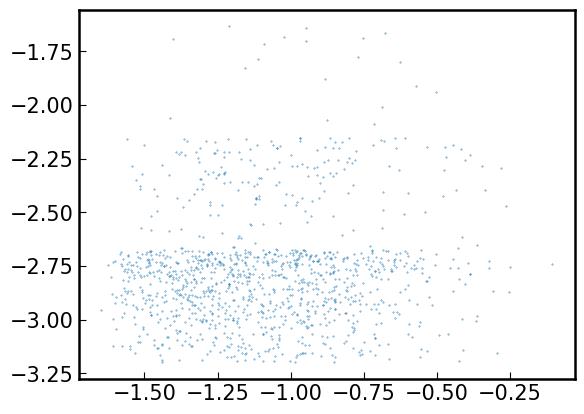

In [97]:
plt.scatter(np.log10(s[f'SFinf_{band}'][mask_mass & mask_mag & mask_var]), np.log10(s[f'lambda_draw'][mask_mass & mask_mag & mask_var]), s=0.1)
#plt.scatter(np.log10(s[f'SFinf_{band}'][mask_mass & mask_mag]), np.log10(s[f'lambda_draw'][mask_mass & mask_mag]), s=.01)


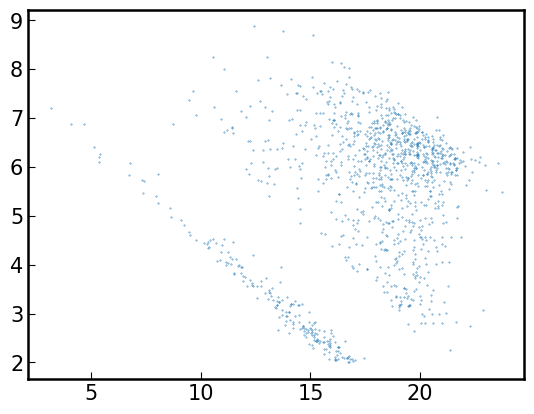

In [98]:
plt.scatter(s[f'm_{band}'][mask_mass & mask_mag & mask_var], np.log10(s[f'M_BH_draw'][mask_mass & mask_mag & mask_var].value), s=0.1)
#plt.scatter(s[f'm_{band}'][mask_mag], np.log10(s[f'M_BH_draw'][mask_mag].value), s=.01)

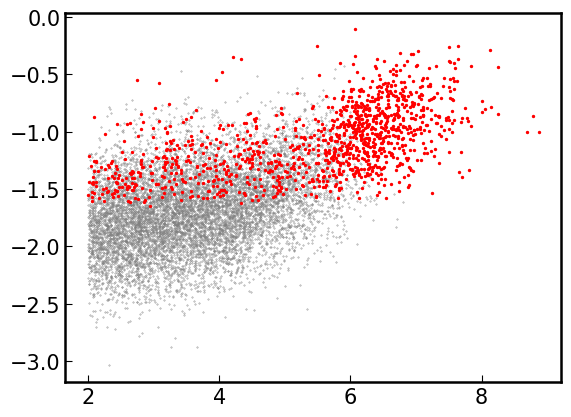

In [144]:
# This doesnt look like what I put in!
plt.scatter(np.log10(s[f'M_BH_draw'][mask_mass & mask_var].value),
            np.log10(s[f'SFinf_{band}'][mask_mass & mask_var]),
            color='red', s=2, zorder=1)
plt.scatter(np.log10(s[f'M_BH_draw'][mask_mass & mask_mag].value),
            np.log10(s[f'SFinf_{band}'][mask_mass & mask_mag]),
            color='gray', s=0.1, zorder=0)

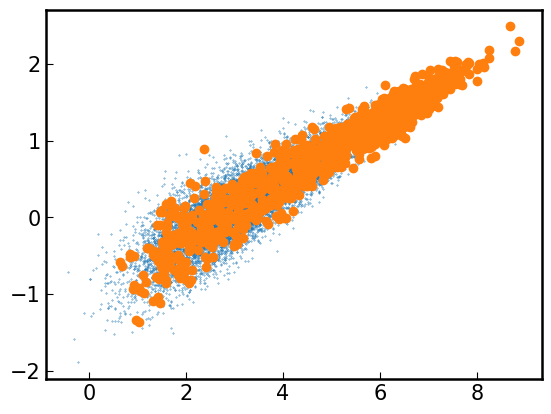

In [103]:
plt.scatter(np.log10(s[f'M_BH_draw'][mask_mag].value), np.log10(s[f'tau_RF_{band}'][mask_mag]), s=.1)
plt.scatter(np.log10(s[f'M_BH_draw'][mask_mag & mask_var].value), np.log10(s[f'tau_RF_{band}'][mask_mag & mask_var]))

No handles with labels found to put in legend.


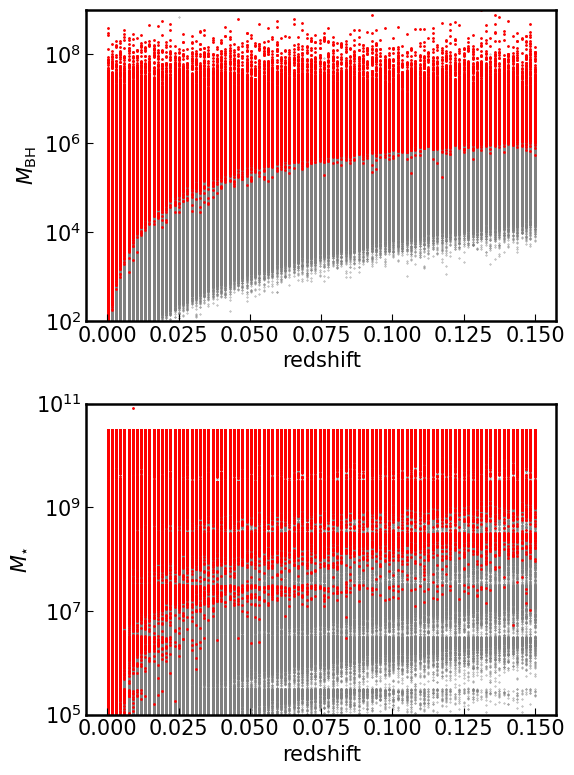

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(6, 8))


mask_mass = s['M_BH_draw'] > 1e2*u.Msun
mask_SF = s[f'SFinf_{band}'] > pm_prec(s[f'm_{band}'])
mask_mag = s[f'm_{band}'] < 25
mask_var = s['sigma_var'] > 3

axs[0].scatter(s['z_draw'][mask_mass & mask_mag], s[f'M_BH_draw'].value[mask_mass & mask_mag], color='gray', s=.1)
axs[0].scatter(s['z_draw'][mask_mass & mask_var], s[f'M_BH_draw'].value[mask_mass & mask_var], color='r', s=1)

axs[0].set_ylim(1e2, 1e9)
axs[0].set_yscale('log')
axs[0].set_xlabel(r'redshift')
axs[0].set_ylabel(r'$M_{\rm{BH}}$')

# 

axs[1].scatter(s['z_draw'][mask_mass & mask_mag], s[f'M_star_draw'].value[mask_mass & mask_mag], color='gray', s=.1)
axs[1].scatter(s['z_draw'][mask_mass & mask_var], s[f'M_star_draw'].value[mask_mass & mask_var], color='r', s=1)

axs[1].set_ylim(1e5, 1e11)
#axs[1].set_xlim(0, 0.15)
axs[1].set_yscale('log')
axs[1].set_xlabel(r'redshift')
axs[1].set_ylabel(r'$M_{\star}$')

ax.legend(fontsize=12)

fig.tight_layout()

/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log10
  if sys.path[0] == '':


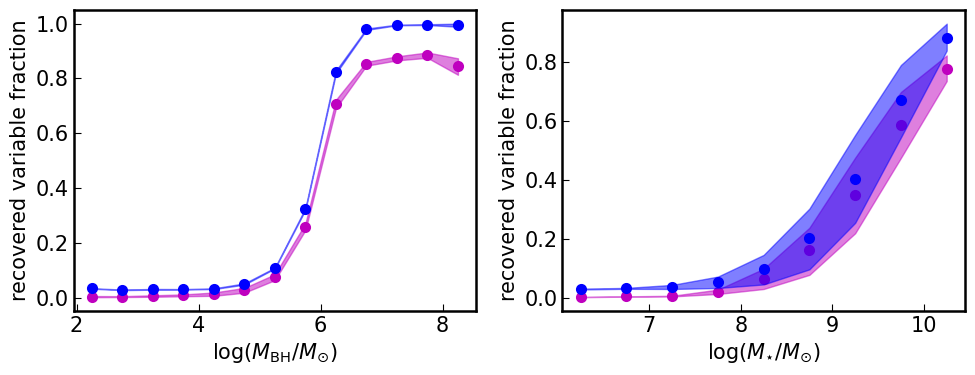

In [17]:
nbootstrap = pars['nbootstrap']

fig, axs = plt.subplots(1, 2, figsize=(5*2, 4))
colors = ['m', 'b']

for i, seed in enumerate(['dc','popIII']):

    bins = np.arange(2, 9, 0.5)

    M_BH = s[f'M_BH_draw_{seed}']
    M_BH_all = s[f'M_BH_draw']
    log_M_BH = np.log10(M_BH.value)
    log_M_BH_all = np.log10(M_BH_all.value)

    f = np.full([nbootstrap, len(bins)-1], np.nan)
    mag_lim = 25.5

    for j in range(nbootstrap):
        ndraw = int(s['ndraws'][j])
        mask_var = s['sigma_var'][j,:ndraw] > 3
        mask_mag = s[f'm_{band}'][j,:ndraw] < mag_lim
        mask_mass = (M_BH[j,:ndraw] > 10**2*u.Msun) # also removes -99
        mask_mass_ = (M_BH_all[j,:ndraw] > 10**2*u.Msun)
        mask_z = s[f'z_draw'][j,:ndraw] < 0.15
        bin_count, bin_edges, binnumber = st.binned_statistic(log_M_BH_all[j,:ndraw][mask_mag & mask_mass_ & mask_z],
                                                              log_M_BH_all[j,:ndraw][mask_mag & mask_mass_ & mask_z],
                                                              statistic='count', bins=bins)
        bin_count_var, bin_edges, binnumber = st.binned_statistic(log_M_BH[j,:ndraw][mask_mass & mask_var & mask_z],
                                                                  log_M_BH[j,:ndraw][mask_mass & mask_var & mask_z],
                                                                  statistic='count', bins=bins)
        bin_width = (bin_edges[1] - bin_edges[0])
        bin_centers = bin_edges[1:] - bin_width/2

        f[j] = bin_count_var/bin_count
        #for i, txt in enumerate(np.char.mod('%d', bin_count_var)):
        #    axs[0].annotate(txt, (bin_centers[i], f[j][i]))
        #    print(txt, bin_centers[i], f[j][i])


    axs[0].fill_between(bin_centers, np.percentile(f, 16, axis=0), np.percentile(f, 84, axis=0), color=colors[i], alpha=0.5)
    axs[0].scatter(bin_centers, np.mean(f, axis=0), lw=2, color=colors[i])
    axs[0].set_ylabel('recovered variable fraction')
    axs[0].set_xlabel(r'$\log(M_{\rm{BH}}/M_{\odot})$')
    #axs[0].set_xlim([2, 9])

    bins = np.arange(6, 11, 0.5)
    M_star = np.log10(s[f'M_star_draw'].value)

    f = np.full([nbootstrap, len(bins)-1], np.nan)

    for j in range(nbootstrap):
        ndraw = int(s['ndraws'][j])
        mask_var = s['sigma_var'][j,:ndraw] > 3
        mask_mag = s[f'm_{band}'][j,:ndraw] < mag_lim
        mask_mass = (M_BH[j,:ndraw] > 10**2*u.Msun)
        mask_mass_ = (M_BH[j,:ndraw] > 10**2*u.Msun) | (M_BH[j,:ndraw] == -99*u.Msun)
        mask_z = s[f'z_draw'][j,:ndraw] < 0.15
        bin_count, bin_edges, binnumber = st.binned_statistic(M_star[j,:ndraw][mask_mag & mask_mass_ & mask_z],
                                                              M_star[j,:ndraw][mask_mag & mask_mass_ & mask_z],
                                                              statistic='count', bins=bins)
        bin_count_var, bin_edges, binnumber = st.binned_statistic(M_star[j,:ndraw][mask_mass & mask_var & mask_z],
                                                                  M_star[j,:ndraw][mask_mass & mask_var & mask_z],
                                                                  statistic='count', bins=bins)
        f[j] = bin_count_var/bin_count

    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    axs[1].fill_between(bin_centers, np.percentile(f, 16, axis=0), np.percentile(f, 84, axis=0), color=colors[i], alpha=0.5)
    axs[1].scatter(bin_centers, np.mean(f, axis=0), lw=2, color=colors[i])
    axs[1].set_ylabel('recovered variable fraction')
    axs[1].set_xlabel(r'$\log(M_{\rm{\star}}/M_{\odot})$')
    #axs[1].set_xlim([6, 11])

fig.tight_layout()
fig.savefig('varfrac.pdf', dpi=300)

In [33]:
bin_count_var

array([ 5.,  1.,  8.,  0., 11.,  4., 34., 11., 50.])

### Visualize SED grid

In [ ]:
model.samples.keys()

In [ ]:
band='SDSS_g'

Text(0.5, 0, 'redshift')

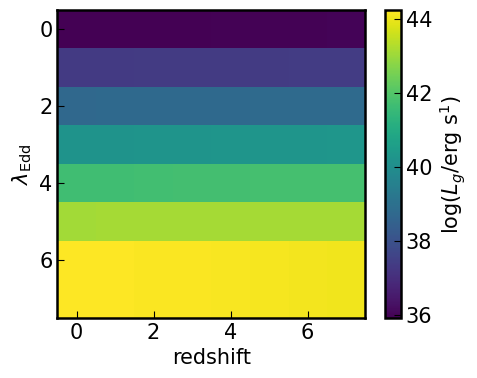

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5*2, 4))
from mpl_toolkits.axes_grid1 import make_axes_locatable

im = ax.imshow(np.log10(model.samples[f'L_{band}_model'][0,:,:].value)) # m, lambda, z
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
fig.colorbar(im, cax=cax)
cax.set_ylabel(r'$\log(L_{g}/{\rm{erg}\ \rm{s}}^{1})$')


ax.set_ylabel(r'$\lambda_{\rm{Edd}}$')
ax.set_xlabel('redshift')

Text(0.5, 0, '$\\lambda_{\\rm{Edd}}$')

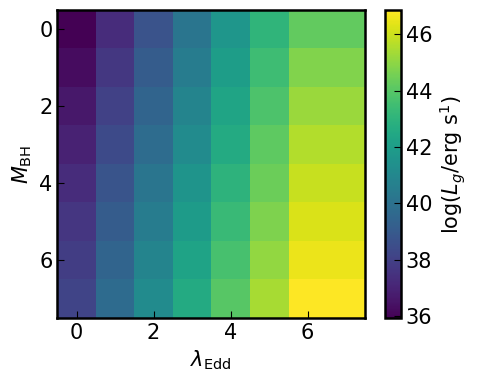

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5*2, 4))
from mpl_toolkits.axes_grid1 import make_axes_locatable

im = ax.imshow(np.log10(model.samples[f'L_{band}_model'][:,:,0].value)) # m, lambda, z
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
fig.colorbar(im, cax=cax)
cax.set_ylabel(r'$\log(L_{g}/{\rm{erg}\ \rm{s}}^{1})$')

ax.set_ylabel(r'$M_{\rm{BH}}$')
ax.set_xlabel(r'$\lambda_{\rm{Edd}}$')

### Example SEDs

In [ ]:
lib = pyphot.get_library()

# if lamb_T has units the Filter object will use those.
#f = pyphot.Filter(lamb_T, T, name='my_filter', dtype='photon', unit='Angstrom') # Import Rubin filters
f = lib['SDSS_g']

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax_top = ax.twiny()

d_c = 30*u.Mpc # Comoving (proper) distance

from astropy.cosmology import z_at_value
z = z_at_value(cosmo.comoving_distance, d_c)
print(z)
d_L = cosmo.luminosity_distance(z)

lambda_Edd = 0.1

# Parameters
pars = {'bh_mass':1e8,'dist_c':d_c.to(u.Mpc).value,'lambda_edd':np.log10(lambda_Edd),'spin':0,'r_cor':100,
        'log_r_out':-1,'kT_e':0.2,'tau':10,'gamma':1.8,'f_pl':0.25,'z':z,'norm':1}
bh_masses = [1e2, 1e4, 1e6, 1e8]*u.Msun

# Set energy range
e0 = (1e8*u.nm).to(u.keV, equivalencies=u.spectral())
e1 = (1e-5*u.nm).to(u.keV, equivalencies=u.spectral())
xspec.AllModels.setEnergies(f"{e0.value} {e1.value} 1000 log")
model_sed = xspec.Model("optxagnf")

for i, M_BH_i in enumerate(bh_masses):
    
    pars['bh_mass'] = M_BH_i.to(u.Msun).value
    model_sed.setPars(list(pars.values()))
    energies = model_sed.energies(0)[::-1]*u.keV # Why N-1?
    # RF -> Obs. frame
    wav = (energies[:-1]).to(u.nm, equivalencies=u.spectral())*(1 + z)
    dwav = np.diff((energies).to(u.AA, equivalencies=u.spectral())*(1 + z))
    
    # E N_E dlogE to nu f_nu
    dlogE = np.diff(np.log10(energies[::-1].value))
    sed = model_sed.values(0)[::-1]/dlogE * u.photon/u.cm**2/u.s 
    nuf_nu = sed.to(u.erg/u.cm**2/u.s, equivalencies=u.spectral_density(wav))
    
    # Make sure the bolmetric luminosities are reasonably close
    f_lambda = nuf_nu/wav
    L_lambda = (f_lambda*4*np.pi*d_L**2).to(u.erg/u.s/u.AA)
    L_bol = (lambda_Edd*1.26e38*u.erg/u.s*M_BH_i/(1*u.Msun)).to(u.erg/u.s)
    # \int f_lambda T dlambda = [erg/s/AA] [AA]
    #print(np.log10(np.trapz(L_lambda.to(u.erg/u.s/u.AA), x=wav.to(u.AA)).value))
    print(np.log10(np.sum(L_lambda*dwav).value), np.log10(L_bol.value))
    
    s = f'$10^{int(np.log10(M_BH_i.to(u.Msun).value))}$'+r'$\ M_{\odot}$'
    ax.loglog(wav.value, nuf_nu.value, color='gray', lw=2, label=s)
    ax_top.loglog(energies.value[:-1], sed, alpha=0, lw=2)
    
    
ys = 2
ax.text(3e2, 1e-8*ys, 'accretion disk', fontsize=12)
ax.text(5e0, 5e-9*ys, 'soft excess', fontsize=12)
ax.text(4e-1, 8e-10*ys, 'power-law tail', fontsize=12)

# Plot bandpasses
colors = ['violet','violet','blue','green','orange','red','black']
bands = ['GALEX_FUV','GALEX_NUV','SDSS_u','SDSS_g','SDSS_r','SDSS_i','SDSS_z']
for i, f in enumerate(bands):
    bandpass = lib[f]
        
    wav_band = (bandpass.wavelength).to(u.nm).value
    wav_band = [np.min(wav_band) - 1e-2] + list(wav_band) + [np.max(wav_band) + 1e-2]
    trans = bandpass.transmit
    trans = [0] + list(trans) + [0]
    
    ax.plot(wav_band, np.array(trans)*1e-9, color=colors[i], zorder=-10)

ax.set_ylim(1e-17, 1e-7)
ax.set_xlim(3e-1, 1e5)

#ax2.set_ylim(1e-14, 1e0)

ax_top.set_xlim(np.max(energies.value), np.min(energies.value))

ax.set_xlabel(r'Wavelength (nm)', fontsize=18)
ax.set_ylabel(r'$\nu\ F_\nu$ (erg cm$^{-2}$ s$^{-1}$)', fontsize=18)
ax_top.set_xlabel(r'Energy (keV)', fontsize=18)

lines = ax.get_lines()
labelLines(lines, zorder=2.5, fontsize=14, align=False,
           backgroundcolor='white', xvals=[2e1,1e4,1e4,1e4]*len(lines))

for ax in [ax, ax_top]:

    ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
    ax.tick_params(axis='both', which='major', length=6)
    ax.tick_params(axis='both', which='minor', length=3)
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='x', which='major', pad=7)

fig.tight_layout()
fig.savefig('sed.pdf', dpi=300)

### Example light curves

In [ ]:
from model import simulate_drw
# Test host diulation
t_rest = np.arange(0, 5000, 1)
# The variable part is measured from quasars
m_var = simulate_drw(np.array([t_rest]).T, np.array([50]), np.array([0]), np.array([18]), np.array([0.5]))
# Now add a host galaxy
m = -2.5*np.log10(10**(-0.4*16) + 10**(-0.4*m_var))
# Now what is the new SF_inft?
print(np.std(m), np.std(m_var))

plt.plot(t_rest, m)

In [ ]:
dm = 0.5
f1 = 10**(-0.4*18)
df = f1*np.log(10)/2.5*dm

f2 = 10**(-0.4*16)

dm_new = 2.5/np.log(10)*df/(f1+f2)

print(dm_new)

In [ ]:
from astropy.io import ascii
dat = ascii.read('s82drw_g.dat')

tau_drw_Macleod = 10**dat['col8']*u.day
z = dat['col4']

edge = dat['col14']
Plike = dat['col15']
Pnoise = dat['col16']
Pinf = dat['col17']
Pmu = dat['col18']

#mask = (dat['col9'] != -10) #& (tau_drw_Macleod*(1+z) < 0.2*365*10*u.day)
mask = (dat['col9'] != -10) & (edge==0) & (Plike-Pnoise>2) & (Plike-Pinf>0.05) #& (tau_drw_Macleod*(1+z) < 0.2*365*10*u.day)

M_BH_Macleod = (10**dat['col6']*u.Msun)[mask]
t = tau_drw_Macleod.to(u.year).value
SF_inf_Macleod = 10**(dat['col9']*(t**0.5))[mask] # log sigma

## ZTF
dat = ascii.read('G_sigdrw_highquality.txt')
SF_inf_ZTF = np.sqrt(2)*dat['sigD']
M_BH_ZTF = 10**dat['mass']

In [ ]:
from model import get_AGN_flux, draw_SFinf

fig, ax = plt.subplots(1, 1, figsize=(5.5,4), sharex=True)

vget_AGN_flux = np.vectorize(get_AGN_flux)

size = 200
M_BH = np.logspace(2, 9, 10)*u.Msun
lambda_Edds = [0.1, 0.01, 0.001] #, 1e-4, 1e-5, 1e-6, 1e-7]

z_ex = 0.007 # ~30 Mpc
f_host = 0.5 #0.5 # host contaimination level

band = 'SDSS_g'
g_minus_i = 0.8 # 0.8

lambda_RF = lib[band].lpivot/(1 + z_ex)

M_i_AGNs = {}

for lambda_Edd in lambda_Edds:

    M_band_AGN, m_band_AGN, L_band_AGN, _ = vget_AGN_flux(model_sed, M_BH.value, lambda_Edd=lambda_Edd, z=z_ex, band=band)
    M_i_AGN, _, _, _ = vget_AGN_flux(model_sed, M_BH.value, lambda_Edd=lambda_Edd, z=2.0, band='SDSS_i')
    L_band_AGN = L_band_AGN*u.erg/u.s
    
    M_i_AGNs[f'{lambda_Edd}'] = M_i_AGN
    SFinf = np.empty([size, len(M_BH)])
    SFinf_host = np.empty([size, len(M_BH)])
        
    for i in range(size):
        # No host contaimination
        SFinf[i,:] = draw_SFinf(np.array([lambda_RF.to(u.AA).value]), np.array([M_i_AGN]), np.array([M_BH.value]), size=1) # Delta mag

        # Use the host M/L ratio to get M_i
        #M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH/(1*u.Msun) + np.random.normal(0.0, 0.5)) - 8.95)/1.40)
        if lambda_Edd == 0.1:
            # Randomize
            M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH/(1*u.Msun) + np.random.normal(0.0, 0.5)) - 7.45)/1.05)
            L_band_host = f_host * M_stellar/(1*u.Msun) / 10**(2.053*g_minus_i - 1.030 + np.random.normal(0.0, 0.3))*u.Lsun
        else:
            M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH/(1*u.Msun)) - 7.45)/1.05)
            L_band_host = f_host * M_stellar/(1*u.Msun) / 10**(2.053*g_minus_i - 1.030)*u.Lsun

        # Including host contaimination
        dL = L_band_AGN*np.log(10)/2.5*SFinf[i,:]
        SFinf_host[i,:] =  2.5/np.log(10)*dL/(L_band_AGN + L_band_host) # These are actually g-band

    # Plot
    if lambda_Edd == 0.1:
        ax.loglog(M_BH, np.median(SFinf, axis=0), color='gray', lw=2)
        ax.fill_between(M_BH, np.percentile(SFinf, 16, axis=0), np.percentile(SFinf, 84, axis=0),
                        color='gray', lw=2, alpha=0.5)

        ax.loglog(M_BH, np.median(SFinf_host, axis=0), color='b', lw=2)
        ax.fill_between(M_BH, np.percentile(SFinf_host, 16, axis=0), np.percentile(SFinf_host, 84, axis=0),
                        color='b', lw=2, alpha=0.5)
    elif lambda_Edd == 0.01:
        ax.loglog(M_BH, np.median(SFinf, axis=0), color='gray', lw=2, linestyle='dashed', alpha=0.3)
        ax.loglog(M_BH, np.median(SFinf_host, axis=0), color='b', lw=2, linestyle='dashed', alpha=0.3)
    else:
        ax.loglog(M_BH, np.median(SFinf, axis=0), color='grey', lw=2, linestyle='dotted', alpha=0.3)
        ax.loglog(M_BH, np.median(SFinf_host, axis=0), color='b', lw=2, linestyle='dotted', alpha=0.3)

# Data
ax.scatter(M_BH_Macleod, SF_inf_Macleod, marker='.', s=1, color='gray', alpha=0.8, label='SDSS quasars', zorder=-10)
ax.scatter(M_BH_ZTF, SF_inf_ZTF, marker='.', color='b', alpha=0.8, label='ZTF dwarf AGNs', zorder=-10)

ax.set_xlabel(r'$M_{\rm{BH}}\ (M_{\odot})$')
ax.set_ylabel(r'$\rm{SF}_{\infty}$ (mag)')
ax.set_xlim([1e2, 1e10])
ax.set_ylim([1e-2, 1e1])

ax.legend(fontsize=10, loc='upper right')
ax.tick_params(axis='x', which='major', pad=7)

fig.tight_layout()
fig.savefig('SFinf.pdf', dpi=300)


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5.5,4))

lambda_Edd = 0.1

L_bol = lambda_Edd*1.26e38*(M_BH/(1*u.Msun))*u.erg/u.s
M_i_AGN_Shen = np.array([90 - 2.5*np.log10(L_bol/(1*u.erg/u.s)) + np.random.normal(0, 0.166)
                         for i in range(size)]) # M_i(z=2) Shen
M_i_AGN = M_i_AGN + 0.5964 # assuming an alpha_nu =-0.5 contiuum spectrum

ax.plot(M_BH, M_i_AGNs[f'{lambda_Edd}'], c='b', lw=3, label='Done et al. 2012')
ax.plot([1e0], [1e0], c='gray', lw=5, label=r'$M_i = 90 - 2.5\ \log(L_{\rm{bol}}\ /\ \rm{erg}\ \rm{s}^{-1})$') # Fake line
ax.fill_between(M_BH, np.percentile(M_i_AGN_Shen, 16, axis=0), np.percentile(M_i_AGN_Shen, 84, axis=0),
                color='gray', lw=3)

ax.set_xscale('log')
ax.set_xlabel(r'$M_{\rm{BH}}\ (M_{\odot})$')
ax.set_ylabel(r'$M_i(z{=}2)$')
ax.legend(fontsize=11, frameon=False)
ax.tick_params(axis='x', which='major', pad=7)

ax.set_xlim(1e2, 1e9)
ax.set_ylim(-26, -2)
fig.tight_layout()
fig.savefig('Mi.pdf', dpi=300)

In [ ]:
from model import draw_tau, simulate_drw

def simulate_lc(t_rest, z=0.0, M_BH=1e6, lambda_Edd=0.1, band='SDSS_g', f_host=0.5,  g_minus_i=0.8, randomize=True):
    
    lambda_RF = lib[band].lpivot/(1 + z)
    
    M_band_AGN, m_band_AGN, L_band_AGN, f_band_AGN = get_AGN_flux(model_sed, M_BH, lambda_Edd=lambda_Edd, z=z, band=band)
    M_i_AGN, _, _, _ = get_AGN_flux(model_sed, M_BH, lambda_Edd=lambda_Edd, z=2.0, band='SDSS_i')
    L_band_AGN = L_band_AGN*u.erg/u.s
    
    # SF_\infy
    SFinf = draw_SFinf(lambda_RF.to(u.AA).value, M_i_AGN, M_BH, size=1, randomize=randomize)
    tau = draw_tau2(lambda_RF.to(u.AA).value, M_i_AGN, M_BH, size=1, randomize=randomize)
    
    # Use the host M/L ratio to get M_i
    if randomize:
        M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH + np.random.normal(0.0, 0.5)) - 7.45)/1.05)
        L_band_host = f_host * M_stellar/(1*u.Msun) / 10**(2.053*g_minus_i - 1.030 + np.random.normal(0.0, 0.3))*u.Lsun
    else:
        M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH) - 7.45)/1.05)
        L_band_host = f_host * M_stellar/(1*u.Msun) / 10**(2.053*g_minus_i - 1.030)*u.Lsun
    
    # Including host contaimination
    dL = L_band_AGN*np.log(10)/2.5*SFinf
    SFinf =  2.5/np.log(10)*dL/(L_band_AGN + L_band_host)
    
    return simulate_drw2(t_rest, tau, z, m_band_AGN, SFinf)

In [ ]:
z_ex = 0.007 # ~30 Mpc

d_L = cosmo.luminosity_distance(z_ex).to(u.cm)
t_obs = np.arange(0, 365*1, .1)

nex = len(bh_masses)
fig, axs = plt.subplots(nex, 1, figsize=(5,2*nex), sharex=True)

M_BH = [1e2, 1e4, 1e6, 1e8]*u.Msun

for i, M_BH_i in enumerate(M_BH):
    # Get the stellar mass
    t_rest = t_obs/(1 + z_ex)
    y = simulate_lc(t_rest, z=z_ex, M_BH=M_BH_i.value, lambda_Edd=0.1, band='SDSS_g', randomize=False)
    ax = axs[len(M_BH) - 1 - i]
    y = y-np.mean(y)
    
    s = r'$M_{\rm{BH}} = '+f'10^{int(np.log10(M_BH_i.value))}$'+r'$\ M_{\odot}$'
    ax.text(0.6, 0.85, s, transform=ax.transAxes, color='k', zorder=1)
    ax.errorbar(t_rest, y, color='b', lw=1, zorder=0, alpha=0.8)
    ax.set_ylabel(r'$\Delta\ g$')
    ax.set_xlim(np.min(t_rest), np.max(t_rest))
    ax.set_ylim(np.mean(y)+0.48, np.mean(y)-0.48)

axs[-1].set_xlabel('time (days)')
fig.tight_layout()
fig.subplots_adjust(hspace=.05, left=0.2, right=0.98)
fig.savefig('lc_examples.pdf', dpi=300)